<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/Topic_Modeling_Reclame_Aqui_with_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with Latent Dirichlet Allocation (LDA) - Reclame Aqui**

LDA is an unsupervised learning algorithm which is able to learns about the structure of the data by analyzing the relationships between words and documents. LDA is based on the idea that each document in a collection can be represented as a mixture of a small number of topics, and that each topic is a distribution over the words in the vocabulary. The model estimates the probability of each word in a document given the topics present in that document, and it also estimates the probability of each topic given the words in the document.

Reference: BLEI, D. M. 2012 Probabilistic topic models. Communications of the ACM, 55(4): pp.77_84.


### **Load data from [Github](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git)**

#### **Load dependecies**

In [3]:
%%capture
try:
  import pandas as pd # for data manipulation
  import os # for interacting with the operating system
  import optuna # for hyperparameter optimization
  import pyLDAvis
  from gensim.utils import simple_tokenize
  from gensim.models import LdaMulticore
  from gensim.utils import simple_preprocess
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from sklearn.cluster import KMeans
  from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
  import matplotlib.pyplot as plt
  import pickle
  import csv
  import pyLDAvis.gensim_models as gs
except:
  !pip install gensim
  !pip install pyldavis
  !pip install optuna
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models import LdaMulticore
  from gensim.utils import simple_preprocess
  import optuna # for hyperparameter optimization

In [4]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui'
DATASETS_DIR = '/content/Topic-Modeling-Reclame-Aqui/datasets'
LDA_RESULTS_DIR = '/content/Topic-Modeling-Reclame-Aqui/lda'

#### **Github**

In [3]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:v/NqWjUxZ39sT+Kg2pIgUZ2Vy7cjByYVW5Xypr92eW0 root@dd2ca77ee4b7
The key's randomart image is:
+---[RSA 4096]----+
|       . ooo.... |
|      . o oo. .  |
|     .   o..ooo  |
|    .   . = .=oo |
|     .  So o++. *|
|    . .  ..o=+ +o|
|     . . .+o o. +|
|        o+o.  o.E|
|        o+++...+.|
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-a17d9d27


In [4]:
! cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDFfYvXCZJKC2XkgA3Vxxt1j2NvpJGw2R44DnIVX6u8jrZoT2U1WWyOZkpLAGhCOcbc28ZkqWoexqj7Ss0otb21Yk4pl7sK930vmwJbRkRi2Ddn4VxK94uDbRF7D9WV+ipZD9Kk5qCJ/mzmC+vghdnplwFrVKarEkCCArNYHcsBlT685yLN8SQq6yLCO1J3zPOkJ43QRsvXMVIgNcfqBvoE8sq+hXc/Yg7mwCRybdlwKmJDLw2uGFIWxslovqDtsi1PfefwQ4acYFetUhu8wDVA37o0tVKnRaXHyAM2V2Uc9zL8lhmArOggV0yX/erkT6nCGRPwdTqMEZrJSnRBZtUdNDfrKkaNPurUnQpHv1yufUdclW8thr/qG5zuV6O9ch6qapvq9wr+RYRC34ytPMUh4IpHUN734CVWE1eyrvekviKb2ggeAaW9iuKjAQw8ey/8D8Jhhy1EWf+KN3g+9WPCqmv6clk2wEEAEIGMgk2JSz8VtK5GRZV02EQvsR161++5HW0+/Akyycq6e5nfnNJt9/3AdSbZ5pWNwAvWp8pR1YJq0Yq5fuDwVU4IK68UrUq5x2kM0f72raaoclm5aFM314tzkCfvAC1pMmWchpE115jXatjlT9ESBNPGcsN2R+0uTM4Mnfo9sTZ0wCX/sFSsTcwVyN/dh6FdeTKmkCnTgQ== root@dd2ca77ee4b7


In [5]:
!git config --global user.email "mattheus_ribeiro@oulook.com"
!git config --global user.name "punkmic"

In [6]:
!ssh -T git@github.com

Hi punkmic! You've successfully authenticated, but GitHub does not provide shell access.


In [8]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 16387, done.
remote: Counting objects: 100% (2206/2206), done.
remote: Compressing objects: 100% (1828/1828), done.
remote: Total 16387 (delta 360), reused 2171 (delta 343), pack-reused 14181
Receiving objects: 100% (16387/16387), 134.90 MiB | 23.53 MiB/s, done.
Resolving deltas: 100% (1508/1508), done.
Checking out files: 100% (14824/14824), done.


In [7]:
%cd /content/Topic-Modeling-Reclame-Aqui/

[Errno 2] No such file or directory: '/content/Topic-Modeling-Reclame-Aqui/'
/content


#### **Load dataset**

In [1]:
DATASET_VERSION = 'v1'

In [5]:
df = pd.read_csv(os.path.join(DATASETS_DIR, f'preprocessed_{DATASET_VERSION}.csv'))

In [6]:
df.head()

,title,documents
0,pedir cancelado justificativa após semana compro,pesquisando bastante novo comprar resolver agu...
1,pedir cancelar,sinceramente decepcionar entrar contato procon...
2,cobrança indever,cancelei plano antes terminar período testir g...
3,pedir reincidente,olhar compra vir errar vir errar novamente fal...
4,assinaturar vender brasil,inscrevi realizar venda brasil cadastro plano ...


#### **K-Means elbow**

In [ ]:
# convert text documents to bag of words representation
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=5000, ngram_range=(1, 3))
x = vectorizer.fit_transform(df.documents.values)

In [ ]:
# use elbow method to find the best number of clusters
NUMBER_OF_CLUSTERS = 50
ls = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x)
    ls.append(kmeans.inertia_)

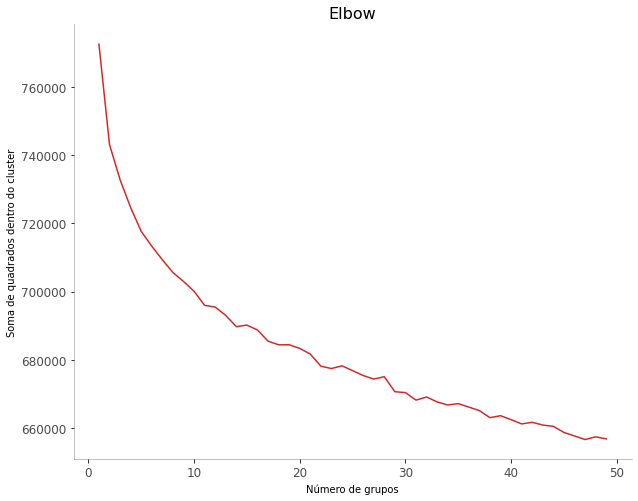

In [19]:
# plot elbow
plt.figure(figsize=[10, 8])
plt.plot(range(1, NUMBER_OF_CLUSTERS), ls, color='tab:red')
plt.title('Elbow', fontsize=16)
plt.xlabel('Número de grupos')
plt.ylabel('Soma de quadrados dentro do cluster')

# decoration
plt.xticks(fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)

# remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)  

if not os.path.exists(LDA_RESULTS_DIR):
  os.makedirs(LDA_RESULTS_DIR)

# save plot
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'elbow_{NUMBER_OF_CLUSTERS}_{DATASET_VERSION}.png'))

# show the plot
plt.show()

#### **LDA**

In [20]:
def get_coherence_score(docs, nr_topics):

  # tokenize the text data
  tokens = [simple_preprocess(doc) for doc in docs]
  # create a corpus from a list of texts
  dictionary = Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]

  # create a new LDA model
  lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_state=100,
                           passes=2,
                           iterations=100)
  
  score = CoherenceModel(lda_model, texts=tokens, corpus=corpus, dictionary=dictionary).get_coherence()
  
  return {'model': lda_model, 'corpus': corpus, 'dictionary': dictionary, 'tokens': tokens}, score

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
NUMBER_OF_TOPICS = 50
topics = list(range(2, NUMBER_OF_TOPICS))
scores = [score for n in topics for _, score in [get_coherence_score(df.documents.values, n)]]

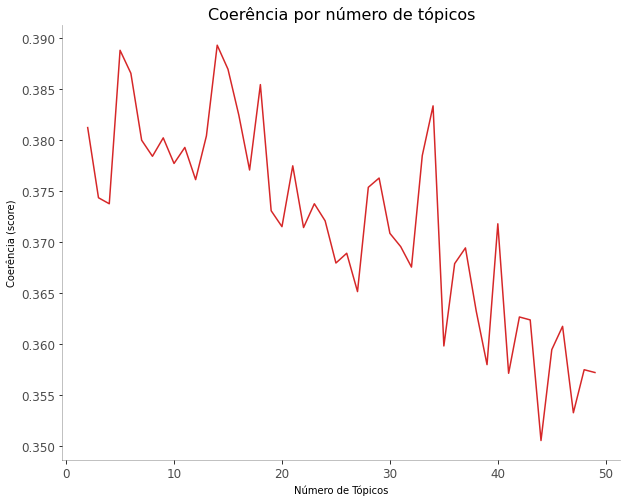

In [22]:
# create the plot
plt.figure(figsize=[10, 8])
plt.plot(topics, scores, color='tab:red')

# add labels to the axes
plt.xlabel('Número de Tópicos')
plt.ylabel('Coerência (score)')

# decoration
plt.xticks(fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Coerência por número de tópicos", fontsize=16)

# remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)

# save plot
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'coherence_by_topics_{NUMBER_OF_TOPICS}_{DATASET_VERSION}.png'))

# show the plot
plt.show()

#### **Bigrams LDA**

In [ ]:
# create a list of lists of bigrams (list of documents)
bigrams = df['noun_bigrams'].tolist()

# Create a dictionary from the bigrams
dictionary = Dictionary(bigrams)

# Create a corpus from the bigrams
corpus = [dictionary.doc2bow(bigram) for bigram in bigrams]

# Create a list to store the coherence scores
coherence_scores = []

# Create LDA models for different number of topics
for num_topics in range(2, 20):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=bigrams,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    coherence_scores.append((num_topics, coherence_model.get_coherence()))

# Print the coherence scores
print(coherence_scores)

#### **Trigrams LDA**

In [ ]:
# create a list of lists of trigrams (list of documents)
trigrams = df['noun_trigrams'].tolist()

# Create a dictionary from the trigrams
dictionary = Dictionary(trigrams)

# Create a corpus from the trigrams
corpus = [dictionary.doc2bow(bigram) for bigram in trigrams]

# Create a list to store the coherence scores
coherence_scores = []

# Create LDA models for different number of topics
for num_topics in range(2, 20):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=trigrams,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    coherence_scores.append((num_topics, coherence_model.get_coherence()))

# Print the coherence scores
print(coherence_scores)

#### **Hyperparameter tuning**

In [29]:
def optimizer(trial):
   alpha = trial.suggest_float('lda_alpha', 0.01, 1.0)
   eta = trial.suggest_float('lda__eta', 0.01, 1.0)

   nr_topics = trial.suggest_int('lda__nr_topics', 2, 50)

   # tokenize the text data
   tokens = [simple_preprocess(doc) for doc in df.documents]
   # create a corpus from a list of texts
   dictionary = Dictionary(tokens)
   corpus = [dictionary.doc2bow(token) for token in tokens]

   # create a new LDA model
   lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_state=100,
                           passes=2,
                           iterations=100,
                           alpha=alpha,
                           eta=eta)
  
   score = CoherenceModel(lda_model, texts=tokens, corpus=corpus, dictionary=dictionary).get_coherence()

   # save scores

   if not os.path.exists(LDA_RESULTS_DIR):
     os.makedirs(LDA_RESULTS_DIR)

   with open(os.path.join(LDA_RESULTS_DIR, f'coherence_scores_{DATASET_VERSION}.csv'), 'a', newline='') as f:
     fieldnames = ['score', 'tópicos', 'alpha', 'eta']
     writer = csv.DictWriter(f, fieldnames=fieldnames)
     data = [{'score': score,
             'tópicos': nr_topics, 
             'alpha': alpha,
             'eta': eta}]
     writer.writerows(data)
   return  1 - score

In [30]:
%%time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
NUMBER_OF_MODELS = 20
# create a new study
study = optuna.create_study(study_name=f'LDA_{DATASET_VERSION}')

# run the optmize function 
study.optimize(optimizer, n_trials=NUMBER_OF_MODELS)

# best
print('Best value %s', study.best_value)
print('Best params: %s', study.best_params)

[I 2023-01-16 15:58:40,447] A new study created in memory with name: LDA_v1
[I 2023-01-16 15:59:04,145] Trial 0 finished with value: 0.6424371241618552 and parameters: {'lda_alpha': 0.7224606382155717, 'lda__eta': 0.9481074903407473, 'lda__nr_topics': 38}. Best is trial 0 with value: 0.6424371241618552.
[I 2023-01-16 15:59:39,874] Trial 1 finished with value: 0.6348919669249093 and parameters: {'lda_alpha': 0.6412491384283134, 'lda__eta': 0.6299061746516339, 'lda__nr_topics': 14}. Best is trial 1 with value: 0.6348919669249093.
[I 2023-01-16 16:00:18,677] Trial 2 finished with value: 0.6420568184615623 and parameters: {'lda_alpha': 0.282853089819002, 'lda__eta': 0.5277451166374771, 'lda__nr_topics': 10}. Best is trial 1 with value: 0.6348919669249093.
[I 2023-01-16 16:00:43,098] Trial 3 finished with value: 0.6352533265244581 and parameters: {'lda_alpha': 0.9602704608334979, 'lda__eta': 0.8794024573030967, 'lda__nr_topics': 16}. Best is trial 1 with value: 0.6348919669249093.
[I 2023-0

Best value %s 0.6197729875499405
Best params: %s {'lda_alpha': 0.6119638941336548, 'lda__eta': 0.15419417862399393, 'lda__nr_topics': 7}
CPU times: user 10min, sys: 30.7 s, total: 10min 31s
Wall time: 10min 55s


In [38]:
scores = pd.read_csv(os.path.join(LDA_RESULTS_DIR, f'coherence_scores_{DATASET_VERSION}.csv'), header=None)
scores.columns = ['score', 'topics', 'alpha', 'eta']
scores.head()

,score,topics,alpha,eta
0,0.357563,38,0.722461,0.948107
1,0.365108,14,0.641249,0.629906
2,0.357943,10,0.282853,0.527745
3,0.364747,16,0.960270,0.879402
4,0.373033,40,0.796522,0.099934


#### **Visualization of Topics**

In [32]:
def save_lda_vis(lda, nr_topics, corpus, dictionary):
  path = os.path.join(LDA_RESULTS_DIR, f'ldavis_{str(nr_topics)}_{DATASET_VERSION}')

  vis = gs.prepare(lda, corpus, dictionary)
 
  with open(path, 'wb') as f:
        pickle.dump(vis, f)

  with open(path, 'rb') as f:
    vis = pickle.load(f)
  
  pyLDAvis.save_html(vis, os.path.join(LDA_RESULTS_DIR, f'ldavis_{str(nr_topics)}_{DATASET_VERSION}.html'))

In [33]:
nr_topics = scores.iloc[1, 1]
alpha = scores.iloc[1, 2]
eta = scores.iloc[1, 3]

# tokenize the text data
tokens = [simple_preprocess(doc) for doc in df.documents]
# create a corpus from a list of texts
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

# create a new LDA model
lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_state=100,
                           passes=2,
                           iterations=100,
                           alpha=alpha,
                           eta=eta)

save_lda_vis(lda_model, nr_topics, corpus, dictionary)

vis = gs.prepare(lda_model, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [34]:
def get_topics(lda, nr_topics):
  x=lda.show_topics(num_topics=nr_topics, num_words=10, formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
  topics = []
  words = []
  for t, w in topics_words:
    topics.append(t)
    words.append(w)
  return pd.DataFrame({'Tópicos': topics, 'Words': words})

In [35]:
def get_words(lda, topics):
  words = []
  for topic_id, topic in enumerate(topics):
    topic_words = [dictionary[word_id] for word_id, prob in lda.get_topic_terms(topic_id, topn=10)]
    words.append(topic_words)
  return words

In [36]:
topics_terms = get_topics(lda_model, nr_topics)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, f'topics_terms_{DATASET_VERSION}.csv'), index=False)
topics_terms.head()

,Tópicos,Words
0,0,"[compra, cartão, crédito, fazer, contar, pois,..."
1,1,"[pedir, compra, contato, fazer, email, resolve..."
2,2,"[produto, pedir, garrafa, compra, chegar, rece..."
3,3,"[produto, pedir, entregar, compra, dia, contat..."
4,4,"[entregar, transportadora, pedir, data, produt..."
